[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [3]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [5]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [6]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [7]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

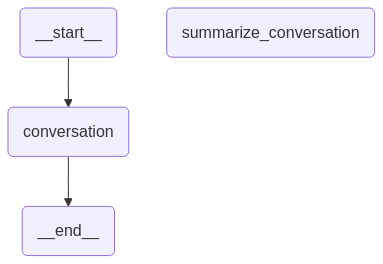

In [8]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation",summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

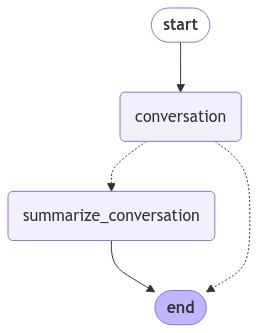

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "111"}}

# Start conversation
# input_message = HumanMessage(content="hi! I'm Lance")
# output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()
print("************************************************************")
# input_message = HumanMessage(content="what's my name?")
# output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()
print("************************************************************")

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! How's it going? What can I do for you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance! How can I help you today?
************************************************************
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================ Human Mes

In [13]:
input_message = HumanMessage(content="Is football and soccer same sport?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you enjoyed?
================================ Human Message =================================

Is football and soccer same sport?
================================== Ai Message ==================================

No, football and soccer are not the same sport, though the term "football" can refer to different sports depending on the region. In the United States and Canada, "football" refers to American football, which is a contact sport played with an oval-shaped ball on a rectangular field with goalposts at each end. In most other parts of the world, "football" refers to what Americans call "soccer," which is played with a round ball on a rectangular field with goals at

In [14]:
input_message = HumanMessage(content="Which team should I support in soccer based on my liking?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you enjoyed?
================================ Human Message =================================

Is football and soccer same sport?
================================== Ai Message ==================================

No, football and soccer are not the same sport, though the term "football" can refer to different sports depending on the region. In the United States and Canada, "football" refers to American football, which is a contact sport played with an oval-shaped ball on a rectangular field with goalposts at each end. In most other parts of the world, "football" refers to what Americans call "soccer," which is played with a round ball on a rectangular field with goals at

In [15]:
input_message = HumanMessage(content="I like Nick Bosa and Michael Ballack, aren't they the best defenders?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

I like Nick Bosa and Michael Ballack, aren't they the best defenders?
================================== Ai Message ==================================

Nick Bosa and Michael Ballack are both highly regarded in their respective sports, but they played different roles. 

- **Nick Bosa** is a defensive end for the San Francisco 49ers in the NFL. He is known for his exceptional pass-rushing ability, strength, and impact on the defensive line. Bosa has been recognized as one of the top defensive players in American football.

- **Michael Ballack**, on the other hand, was a professional soccer player from Germany. While he was an outstanding player, he was primarily known as a midfielder rather than a defender. Ballack was celebrated for his leadership, versatility, and ability to score goals, making significant contributions to both his club teams and the German national team.

Both athletes are considered amo

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()
print("************************************************************")
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()
print("************************************************************")

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Welcome back. How's your day going?
************************************************************
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Welcome back. How's your day going?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance. How can I assist you today?
************************************************************
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hi Lance! Welcome back. 

Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [13]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and shared his enthusiasm for the San Francisco 49ers, noting the team's rich history and passionate fan base. He was asked about his favorite player or memorable game. Lance reintroduced himself, and the conversation continued with a friendly greeting. The interaction has been casual, focusing on Lance's interest in the 49ers. Recently, Lance reintroduced himself again, and the conversation maintained its friendly tone, with an inquiry about how his day was going."

The `config` with thread ID allows us to proceed from the previously logged state!

In [14]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

i like Nick Bosa, isn't he the highest paid defensive player?
================================== Ai Message ==================================

Yes, Nick Bosa became the highest-paid defensive player in NFL history when he signed a five-year contract extension with the San Francisco 49ers in September 2023. His impact on the field is tremendous, and he's a key player for the team's defense. It's no surprise he's a favorite among fans!


In [15]:
graph.get_state(config).values.get("summary","")

"Lance expressed his admiration for the San Francisco 49ers, highlighting his interest in Nick Bosa, whom he noted as the highest-paid defensive player. The conversation acknowledged Bosa's significant impact on the team and his status as a fan favorite. The interaction has remained casual and friendly, centered around Lance's enthusiasm for the 49ers and his favorite player."

## LangSmith

Let's review the trace!